## Final Project - Basics of deep learning

---
<br>

### Name and ID:
Student 1: Eyal Pasha, 213957814
<br>
Student 2: Nir Tuttnauer, 208585422

## **Chest X-Ray Images (Pneumonia) Dataset**


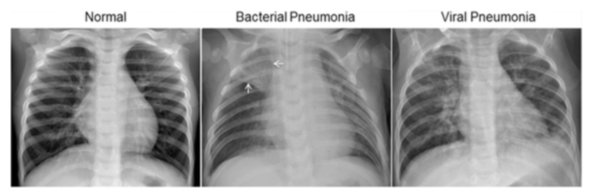

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Link: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


<br>
<br>
Content:

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

<br>

Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2


## **Setup**

**Imports**

In [1]:
import os
import shutil
import numpy as np
import zipfile
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import  SGD
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Input, Concatenate, UpSampling2D, ReLU)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Functions**

In [2]:
def model_full_report(model,history, test_generator):
    # Plot training and validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Make predictions using the model
    predictions = model.predict(test_generator)

    # Get predicted labels (argmax to get the class with the highest probability)
    predicted_labels = predictions.argmax(axis=1)

    # Get true labels
    true_labels = test_generator.classes

    # Generate a classification report
    report = classification_report(true_labels, predicted_labels)

    # Print the classification report
    print("Classification Report:\n", report)
    
def save_model(model, model_filename='unnamed.h5'):
    weights_filename = os.path.splitext(model_filename)[0] + '_w.h5'
    model.save(model_filename)
    model.save_weights(weights_filename)

def save_history(history, filename='unnamed.npy'):
    np.save(filename, history)

def load_saved_model(model_filename='unnamed.h5'):
    return load_model(model_filename)

def load_saved_history(filename='unnamed.npy'):
    return np.load(filename, allow_pickle=True).item()

class Config:
    def __init__(self, img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001):
        self.img_width = img_width
        self.img_height = img_height
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def generate_data(self, train_data_dir, test_data_dir):
        # Data augmentation for training set
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Only rescaling for validation/test set
        test_datagen = ImageDataGenerator(rescale=1. / 255)

        # Generating training set
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating validation set
        validation_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating test set
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False  # Ensure the order of predictions matches the order of actual labels
        )

        return train_generator, validation_generator, test_generator


**GPU Check Script** (for apple silicon)

In [ ]:
# import tensorflow as tf

# cifar = tf.keras.datasets.cifar100
# (x_train, y_train), (x_test, y_test) = cifar.load_data()
# model = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights=None,
#     input_shape=(32, 32, 3),
#     classes=100,)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
# model.fit(x_train, y_train, epochs=5, batch_size=64)

**For Google Drive**

In [ ]:
# drive.mount('/content/drive')

**Data extraction and reorganization**

In [7]:
# Specify the path to the zip file and the extraction directory
zip_path = 'dataset.zip'
extracted_path = 'dataset'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Function to delete a directory and its contents
def delete_directory(path):
    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' successfully deleted.")
    except FileNotFoundError:
        print(f"Directory '{path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define the paths to the directories you want to delete
dir_to_delete1 = 'dataset/chest_xray/__MACOSX'
dir_to_delete2 = 'dataset/chest_xray/val'
dir_to_delete3 = 'dataset/chest_xray/chest_xray/val'

# Delete the first directory
delete_directory(dir_to_delete1)

# Move NORMAL images from val to train
src_path_normal = 'dataset/chest_xray/val/NORMAL'
dest_path_normal = 'dataset/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_normal):
    shutil.move(os.path.join(src_path_normal, filename), os.path.join(dest_path_normal, filename))

# Move PNEUMONIA images from val to val/NORMAL
src_path_pneumonia = 'dataset/chest_xray/val/PNEUMONIA'
dest_path_pneumonia = 'dataset/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia):
    shutil.move(os.path.join(src_path_pneumonia, filename), os.path.join(dest_path_pneumonia, filename))

# Move NORMAL images from chest_xray/val to chest_xray/train
src_path_chest_xray_normal = 'dataset/chest_xray/chest_xray/val/NORMAL'
dest_path_chest_xray_normal = 'dataset/chest_xray/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_chest_xray_normal):
    shutil.move(os.path.join(src_path_chest_xray_normal, filename), os.path.join(dest_path_chest_xray_normal, filename))

# Move PNEUMONIA images from chest_xray/val to chest_xray/val/NORMAL
src_path_pneumonia_chest_xray = 'dataset/chest_xray/chest_xray/val/PNEUMONIA'
dest_path_pneumonia_chest_xray = 'dataset/chest_xray/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia_chest_xray):
    shutil.move(os.path.join(src_path_pneumonia_chest_xray, filename), os.path.join(dest_path_pneumonia_chest_xray, filename))

# Delete the 'val' folders
delete_directory(dir_to_delete2)
delete_directory(dir_to_delete3)

# Define the paths for the test directory
test_dir = 'dataset/chest_xray/chest_xray/test'
src_path_pneumonia_test = os.path.join(test_dir, 'PNEUMONIA')
dest_path_bacterial = os.path.join(test_dir, 'BACTERIAL')
dest_path_viral = os.path.join(test_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders
os.makedirs(dest_path_bacterial, exist_ok=True)
os.makedirs(dest_path_viral, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_test):
    src_file_path = os.path.join(src_path_pneumonia_test, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the test directory
delete_directory(src_path_pneumonia_test)

# Define the paths for the train directory
train_dir = 'dataset/chest_xray/chest_xray/train'
src_path_pneumonia_train = os.path.join(train_dir, 'PNEUMONIA')
dest_path_bacterial_train = os.path.join(train_dir, 'BACTERIAL')
dest_path_viral_train = os.path.join(train_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders in the train directory
os.makedirs(dest_path_bacterial_train, exist_ok=True)
os.makedirs(dest_path_viral_train, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_train):
    src_file_path = os.path.join(src_path_pneumonia_train, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial_train, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral_train, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the train directory
delete_directory(src_path_pneumonia_train)

# Display success message
print("Data extraction, modification, and splitting completed.")

Directory 'dataset/chest_xray/__MACOSX' successfully deleted.
Directory 'dataset/chest_xray/val' successfully deleted.
Directory 'dataset/chest_xray/chest_xray/val' successfully deleted.
Directory 'dataset/chest_xray/chest_xray/test/PNEUMONIA' successfully deleted.
Directory 'dataset/chest_xray/chest_xray/train/PNEUMONIA' successfully deleted.
Data extraction, modification, and splitting completed.


Unmount for Drive

In [ ]:
# drive.flush_and_unmount()

## **Task 1 - Binary Classifiaction**

**Preping the data**

In [4]:
# Set the paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# # Set the paths for drive
# train_data_dir = 'content/dataset/chest_xray/train'
# test_data_dir = 'content/dataset/chest_xray/test'

# Define parameters
config = Config(img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001)

# Generate data using the config
train_generator, validation_generator, test_generator = config.generate_data(train_data_dir, test_data_dir)


Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Subset train**

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(config.img_width, config.img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=500 // config.batch_size,
    epochs=config.epochs,
    validation_data=validation_generator,
    validation_steps=100 // config.batch_size
)


# Evaluate the model on the test set
eval_result = model.evaluate(test_generator, verbose=1)

# Print the evaluation results
print("Test Accuracy:", eval_result[1])

Epoch 1/10
15/15 [==============================] - 7s 437ms/step - loss: 4.1313 - accuracy: 0.5562 - val_loss: 5.3738 - val_accuracy: 0.3333
Epoch 2/10
15/15 [==============================] - 6s 419ms/step - loss: 5.3015 - accuracy: 0.2521 - val_loss: 3.8374 - val_accuracy: 0.4062
Epoch 3/10
15/15 [==============================] - 6s 414ms/step - loss: 3.6587 - accuracy: 0.2708 - val_loss: 2.6382 - val_accuracy: 0.3958
Epoch 4/10
15/15 [==============================] - 6s 416ms/step - loss: 2.3426 - accuracy: 0.2521 - val_loss: 1.8000 - val_accuracy: 0.3438
Epoch 5/10
15/15 [==============================] - 6s 413ms/step - loss: 1.2429 - accuracy: 0.2875 - val_loss: 0.8990 - val_accuracy: 0.4062
Epoch 6/10
15/15 [==============================] - 6s 430ms/step - loss: 0.6864 - accuracy: 0.5542 - val_loss: 0.5913 - val_accuracy: 0.7500
Epoch 7/10
15/15 [==============================] - 6s 403ms/step - loss: 0.7739 - accuracy: 0.7750 - val_loss: 1.5621 - val_accuracy: 0.6354
Epoch 

**Save The Subset Model**

In [5]:
name = 'model_subset_bin_10ep_32bs_256x256 '
save_model(model,name+'.h5')
save_history(history, name+'.npy')

INFO:tensorflow:Assets written to: model_subset_bin/assets


INFO:tensorflow:Assets written to: model_subset_bin/assets


**Full train**

In [0]:
model_full = Sequential()

model_full.add(Conv2D(32, (3, 3), input_shape=(config.img_width, config.img_height, 3), activation='relu'))
model_full.add(MaxPooling2D(pool_size=(2, 2)))

model_full.add(Flatten())
model_full.add(Dense(64, activation='relu'))
model_full.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=config.learning_rate)
model_full.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_full = model_full.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // config.batch_size,
    epochs=config.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // config.batch_size
)
model_full.save('models/1/binary_classification_model_full_dataset.h5')
model_full.save_weights('models/1/binary_classification_weights_full_dataset.h5')
save_history(model_full,'models/1/binary_classification_history_full_dataset.npy')

# Evaluate the model on the test set
eval_result = model_full.evaluate(test_generator, verbose=1)

# Print the evaluation results
print("Test Accuracy:", eval_result[1])

2. **Task 2 - Multi-Class Classification**

**Data prep**

In [16]:
# Set paths
train_data_dir_multi = 'dataset/chest_xray/chest_xray/train'
test_data_dir_multi = 'dataset/chest_xray/chest_xray/test'

# Data generator with data augmentation for training
train_datagen_multi = ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         rotation_range=15)  # Experiment with rotation range


# Data generator for validation and test (no augmentation)
val_test_datagen_multi = ImageDataGenerator(rescale=1./255)

# Parameters
img_width, img_height = 256, 256
batch_size = 16  # Adjusted for a smaller batch size

# Data generators with black and white images
train_generator_multi = train_datagen_multi.flow_from_directory(train_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

val_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

test_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

Found 5224 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


**Full train:**

In [18]:
base_model_full = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze pre-trained layers
for layer in base_model_full.layers:
    layer.trainable = False

# Create a new model with a single-channel input
single_channel_input = Input(shape=(img_width, img_height, 1))
repeated_channel_input = Concatenate()([single_channel_input, single_channel_input, single_channel_input])

# Use the repeated channel input as input to the pre-trained VGG16 model
x = base_model_full(repeated_channel_input)

# Flatten the output of the VGG16 model
x = Flatten()(x)

# Add custom dense layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)  # Adjust for the number of classes

# Create the model
model_transfer_full = Model(inputs=single_channel_input, outputs=output_layer)

# Compile the model
model_transfer_full.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.0001),
                      metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
hist_transfer_full = model_transfer_full.fit(train_generator_multi,
                                   steps_per_epoch=train_generator_multi.samples // batch_size,
                                   epochs=15,
                                   validation_data=val_generator_multi,
                                   validation_steps=len(val_generator_multi),
                                   callbacks=[early_stopping])

# Save the weights
save_model(model_transfer_full, 'models/2/multi_full.h5')
save_history(hist_transfer_full, 'models/2/multi_full.npy')

# Evaluate on the test set
eval_result_transfer = model_transfer_full.evaluate(test_generator_multi, verbose=1)
print("Test Accuracy (Transfer Learning):", eval_result_transfer[1])

Epoch 1/15
326/326 [==============================] - 54s 162ms/step - loss: 0.7144 - accuracy: 0.7106 - val_loss: 1.0044 - val_accuracy: 0.5657
Epoch 2/15
326/326 [==============================] - 53s 164ms/step - loss: 0.5527 - accuracy: 0.7690 - val_loss: 1.6681 - val_accuracy: 0.5272
Epoch 3/15
326/326 [==============================] - 53s 162ms/step - loss: 0.5251 - accuracy: 0.7702 - val_loss: 0.5891 - val_accuracy: 0.8173
Epoch 4/15
326/326 [==============================] - 53s 162ms/step - loss: 0.5203 - accuracy: 0.7752 - val_loss: 0.4812 - val_accuracy: 0.8237
Epoch 5/15
326/326 [==============================] - 53s 161ms/step - loss: 0.5061 - accuracy: 0.7834 - val_loss: 0.7037 - val_accuracy: 0.7740
Epoch 6/15
326/326 [==============================] - 54s 166ms/step - loss: 0.4793 - accuracy: 0.7934 - val_loss: 0.4381 - val_accuracy: 0.8782
Epoch 7/15
326/326 [==============================] - 52s 160ms/step - loss: 0.4794 - accuracy: 0.7903 - val_loss: 0.4272 - val_ac

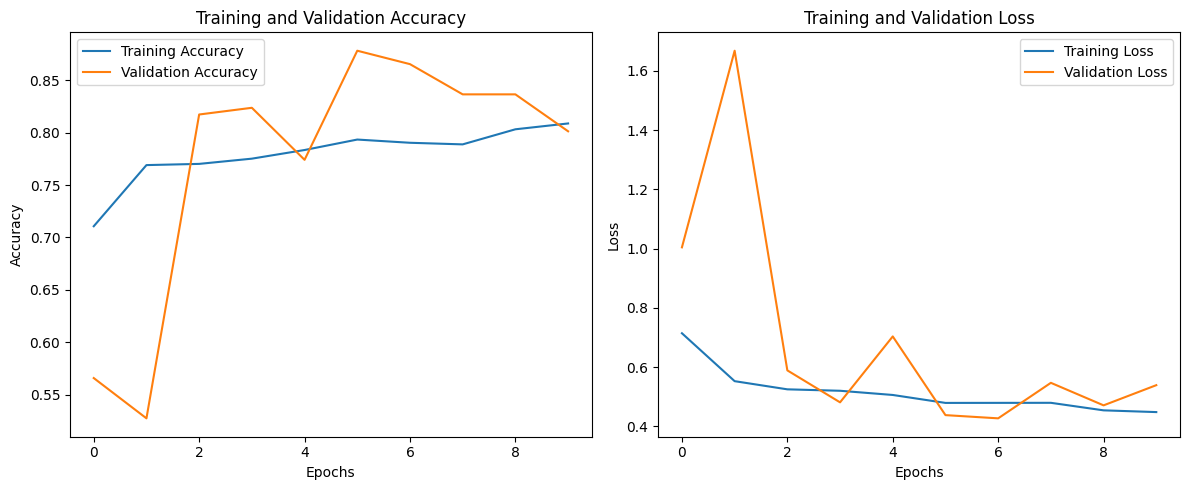

39/39 [==============================] - 5s 137ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.40      0.40       234
           1       0.43      0.46      0.45       242
           2       0.26      0.24      0.25       148

    accuracy                           0.38       624
   macro avg       0.37      0.37      0.37       624
weighted avg       0.38      0.38      0.38       624


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

hist_transfer_full = load_saved_history('models/1/multi_full.npy')

# Plot training and validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_transfer_full.history['accuracy'], label='Training Accuracy')
plt.plot(hist_transfer_full.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist_transfer_full.history['loss'], label='Training Loss')
plt.plot(hist_transfer_full.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('models/1/multi_full_report.png')
plt.show()

predictions = model_transfer_full.predict(test_generator_multi)

# Get predicted labels (argmax to get the class with the highest probability)
predicted_labels = predictions.argmax(axis=1)

# Get true labels
true_labels = test_generator_multi.classes

# Generate a classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:\n", report)


# **Task 3/4 - Anomaly Detection**

In [25]:
from keras.src.callbacks import ModelCheckpoint

# Set paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# Parameters
img_width, img_height = 256, 256  # Adjusted target size
batch_size = 32  # Adjusted batch size
epochs = 500 # Adjusted number of epochs
# Data generator for training (no data augmentation for anomaly detection)
train_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='input',  # Input and target are the same (autoencoder)
                                                    color_mode='grayscale',
                                                    classes=['NORMAL'])
test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='input',  # Input and target are the same (autoencoder)
                                                        color_mode='grayscale',
                                                        classes=['NORMAL'])

anomoly_generator= train_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='input',  # Input and target are the same (autoencoder)
                                                        color_mode='grayscale',
                                                        classes=['PNEUMONIA'])

# Autoencoder model with perceptual loss (4 layers in encoder and decoder)
input_img = Input(shape=(img_width, img_height, 1))
x = Conv2D(256, (3, 3), activation=None, padding='same')(input_img)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# x = Conv2D(16, (3, 3), activation=None, padding='same')(x)
# x = BatchNormalization()(x)
# # x = Dropout(0.2)(x)
# x = ReLU()(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# 
# x = Conv2D(16, (3, 3), activation=None, padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)
# x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation=None, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

checkpoint_filepath = f'models/4/autoencoder_checkpoint{epochs}.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save only weights
    monitor='val_loss',     # Monitor validation loss
    mode='min',             # Mode can be 'min' or 'max' depending on the metric being monitored
    save_best_only=False,     # Save only the best model (lowest validation loss)
    verbose=1                # Verbosity level
)

callbacks = [EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True), checkpoint_callback]
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error', metrics=['mse', 'accuracy'])
autoencoder.summary()
# Train the autoencoder with perceptual loss on normal images
history = autoencoder.fit(train_generator,
                          steps_per_epoch=len(train_generator),
                          validation_data=test_generator,
                          validation_steps=len(test_generator),
                          epochs=epochs,
                          shuffle=True,
                          callbacks=callbacks)


loss_normal = autoencoder.evaluate(test_generator, verbose=0)
print(f"Reconstruction loss on normal images: {loss_normal}")
# Evaluate on sick images
loss_sick = autoencoder.evaluate(anomoly_generator, verbose=0)
threshold = 0.00001  # Adjust this threshold based on your evaluation
predictions_sick = (loss_sick[0] > threshold)
print(f"Anomaly detected: {predictions_sick}")



autoencoder.save(f'models/4/autoencoder_model_crops_{epochs}e.h5')
autoencoder.save_weights(f'models/4/autoencoder_weights_crops_{epochs}e.h5')
save_history(autoencoder,f'models/4/autoencoder_history_crops_{epochs}e.npy')

Found 1349 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Found 390 images belonging to 1 classes.
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_203 (Conv2D)         (None, 256, 256, 256)     2560      
                                                                 
 batch_normalization_184 (B  (None, 256, 256, 256)     1024      
 atchNormalization)                                              
                                                                 
 re_lu_184 (ReLU)            (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 128, 128, 256)     0         
 ng2D)                                                           


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_203 (Conv2D)         (None, 256, 256, 256)     2560      
                                                                 
 batch_normalization_184 (B  (None, 256, 256, 256)     1024      
 atchNormalization)                                              
                                                                 
 re_lu_184 (ReLU)            (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 128, 128, 256)     0         
 ng2D)                                                           
                                                                 
 conv2d_204 (Conv2D)         (None, 128, 128, 128)     295

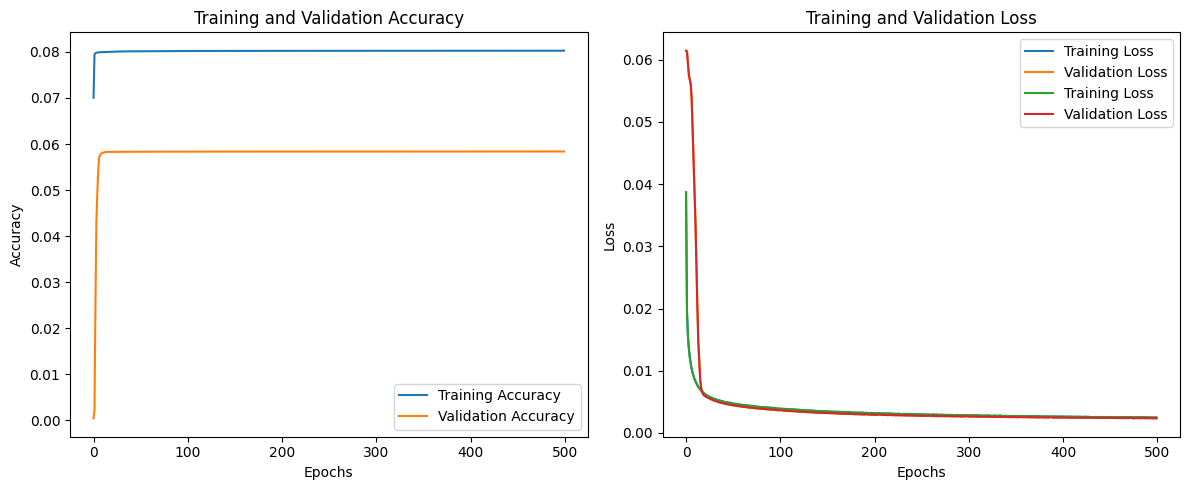

8/8 [==============================] - 10s 1s/step


ValueError: Found input variables with inconsistent numbers of samples: [234, 256]

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
os.makedirs('imgs/4', exist_ok=True)
autoencoder = load_model(f'models/4/autoencoder_model_crops_{epochs}e.h5')
autoencoder.load_weights(f'models/4/autoencoder_weights_crops_{epochs}e.h5')
autoencoder.summary()

# Plot training and validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# plot reconstruction loss
plt.plot(history.history['mse'], label='Training Loss')
plt.plot(history.history['val_mse'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
 
# Show the plots
plt.tight_layout()
plt.savefig('models/4/autoencoder_report_crops_10e.png')
plt.show()

predictions = autoencoder.predict(test_generator)

# Get predicted labels (argmax to get the class with the highest probability)
predicted_labels = predictions.argmax(axis=0)

# Get true labels
true_labels = test_generator.classes

# Generate a classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:\n", report)


Python(12124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


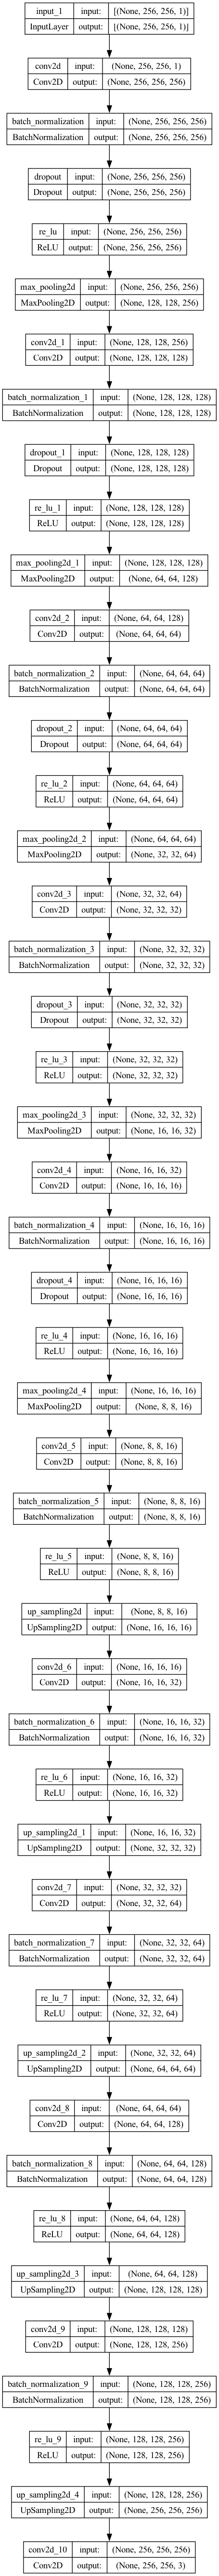

In [6]:
from keras.utils import plot_model
os.makedirs('imgs/4', exist_ok=True)
plot_model(autoencoder, to_file=f'imgs/4/autoencoder_plot_{epochs}e.png', show_shapes=True, show_layer_names=True)
